# Clustering algorithms

`Unsupervised learning I` `Author: Emily Hunt`

## Introduction

### A primer on unsupervised ML

We saw yesterday how **supervised machine learning** is an extremely powerful tool for solving many problems in astronomy. But what should we do if we don't have training data?

**Unsupervised machine learning** is a family of methods that can allow for classification and regression **without** training data. Instead, they use a number of **tunable parameters** to control how they (attempt to) extract features from data.

This makes them into a great family of methods for blind (unbiased) data exploration. However, we'll also learn how unsupervised approaches are only as good as the algorithm they use or the parameters you set, and we'll learn about how fiddly and unreliable they can also be to use. As with any method in astronomy: batteries are not included! (Which is to say, you have to use them carefully.)

### Clustering algorithms

**Clustering algorithms** are a family of unsupervised methods that can extract natural clusters from data. This makes them somewhat analogous to supervised classifiers, as they 'classify' your data into different clusters. However, this is only possible by assuming that your data _is_ clustered in some way. If your dataset doesn't have well-separated classes, applying clustering algorithms is a lot harder.

They also typically work best on low-dimensionality data (up to ~10-50 dimensions), so you can't apply a clustering algorithm to a more complicated type of data (like images) without some kind of preprocessing.

Clustering algorithms do have some benefits. For instance, some algorithms - especially **density-based** ones - can also be used for outlier detection / noise removal: being able to classify something as not being a member of _any_ class is a desirable property.

### The wide range of clustering algorithms

In this tutorial, we'll just be using the clustering algorithms available in [scikit-learn](https://scikit-learn.org/stable/modules/clustering.html). At the time of writing, it includes **twelve** different algorithms, each with different pros and cons.

The following graphic from the scikit-learn docs shows the twelve different algorithms applied to different kinds of (2D) data:

<div>
    <img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_001.png" width="600"/>
</div>

It's already apparent that each algorithm does better or worse for different types of data.

It can be difficult to put many clustering algorithms in one 'box', as many methods have similar (and different) properties, but most algorithms have one or more of the following properties:

- **Centroid-fitting** algorithms (like K-Means, Gaussian mixture models) perform iterative steps to find natural centers of clusters
- **Hierarchical algorithms** (the AgglomerativeClustering family of methods in scikit-learn) try to find hierarchy in a dataset and use some heuristic to decide how much subclustering to accept
- **Density-based algorithms** (DBSCAN, OPTICS, HDBSCAN) use the distances between points as an approximation of local density, in conjunction with a few parameters to decide which clusters to extract.

## Imports, dependencies, & basic helpers

In [4]:
# Uncomment the below to install packages you will need:
# !pip install scikit-learn numpy<2.0 pandas astropy astroquery

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import (
    KMeans,
    SpectralClustering,
    AgglomerativeClustering,
    DBSCAN,
    HDBSCAN,
)
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.datasets import make_blobs, make_moons, make_s_curve

In [2]:
def plot_clusters(
    data: np.ndarray,
    labels: np.ndarray,
    probabilities: np.ndarray | None = None,
    cmap: str = "tab10",
    noise_alpha: float = 0.5,
    figure_kwargs: dict | None = None,
    scatter_kwargs: dict | None = None,
    x_column: int = 0,
    y_column: int = 1,
    title: str = "",
    algorithm=None,
):
    """Plots a default scikit-learn clustering result, or a dataset when true labels
    are known.
    """
    if figure_kwargs is None:
        figure_kwargs = dict()
    if scatter_kwargs is None:
        scatter_kwargs = dict()

    colors = "k"
    if labels is not None:
        # Small trick to get colours for each cluster from any discrete matplotlib colormap
        colors = plt.get_cmap(cmap)(labels)

        # Add probabilities too
        if probabilities is not None:
            colors[:, -1] = probabilities

        # Replace 'noise' points (with a label of -1) with black
        bad_labels = labels == -1
        colors[bad_labels] = np.tile(
            (0.0, 0.0, 0.0, noise_alpha), (bad_labels.sum(), 1)
        )

    # Make the plot
    fig, ax = plt.subplots(**figure_kwargs)
    ax.scatter(data[:, x_column], data[:, y_column], c=colors)

    ax.set(xlabel=f"$x_{x_column}$", ylabel=f"$x_{y_column}$", title=title)
    if algorithm is not None:
        ax.set_title(
            str(algorithm.__class__).rsplit(".")[-1][:-2] + " " + title
        )

    return fig, ax

## How to use the clustering algorithms in scikit-learn

scikit-learn is a great 'one-stop-shop' for popular clustering algorithms that can solve many different problems. It has a very consistent API*, making it easy to try different algorithms.

*API - _'application programming interface'_: the fancy name for how its interface to everything it can do is set up

Let's make a basic 2D test dataset of a few Gaussians to demonstrate this:

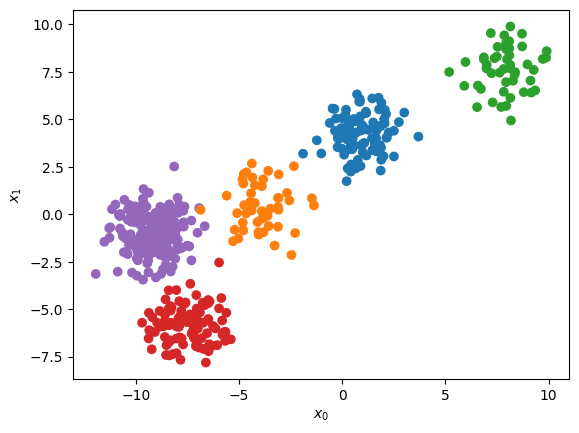

In [3]:
# Parameters
seed = 3  # It's a very good idea to always use a set seed for reproducibility
dimensions = 2
cluster_sizes = [100, 50, 50, 100, 200]

# Make the data
data, true_labels = make_blobs(n_samples=cluster_sizes, n_features=2, random_state=seed)

_ = plot_clusters(data, true_labels)

Applying a clustering algorithm with scikit-learn is easy. Firstly, [look it up in the documentation](https://scikit-learn.org/stable/modules/clustering.html) to work out which parameters it needs. We'll try the easiest one - [K Means clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) - which has a single parameter, the number of clusters n_clusters.

The method starts with a random initialization - for reproducibility, we'll make sure to set it to something consistent.

We start by initializing a clustering object:

In [4]:
clusterer = KMeans(n_clusters=5, random_state=42)

Then, we can use the fit_predict method to both fit the algorithm _and_ predict labels for our data (a shorthand for calling `predict(fit(...))`). The data needs to have shape `n_samples, n_features` (i.e. number of points, number of dimensions):

In [5]:
print(f"Data shape: {data.shape}")

labels = clusterer.fit_predict(data)

Data shape: (500, 2)


All clustering algorithms produce an array of _labels_, which tell you the algorithm's predicted class for the object. Let's look at the predicted labels for the first ten:

In [6]:
labels[:10]

array([3, 4, 0, 3, 3, 0, 3, 3, 4, 3], dtype=int32)

It put them all in the same cluster, which is good!

Some algorithms also predict the probability that a given point is in a cluster. In that way, points can actually be a member of multiple clusters (this is especially the case for Gaussian mixtures.)

Let's plot the output:

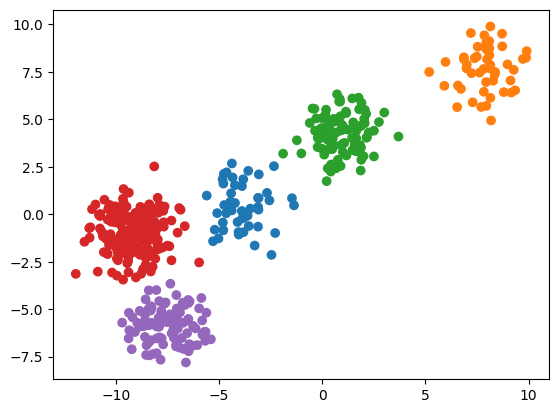

In [7]:
plt.scatter(data[:, 0], data[:, 1], color=plt.get_cmap("tab10")(labels))

Perfect! It correctly identified all five clusters we put into the dataset.

If using clustering algorithms was always easy, this is where the tutorial would stop. But alas, it often isn't; and can require making informed choices about the algorithm you use and the parameters you pick.

## EXERCISE 1: trying out different clustering algorithms

Let's start by trying a few different algorithms on a test dataset. Let's focus on a few popular ones. I've put their most important parameters below for this exercise:

* `KMeans(n_clusters=int, random_state=...)`
* `SpectralClustering(n_clusters=int, random_state=...)`
* `AgglomerativeClustering(n_clusters=int, linkage={‘ward’, ‘complete’, ‘average’, ‘single’})`
* `DBSCAN(eps=float, min_samples=int)`
* `HDBSCAN(min_cluster_size=int, min_samples=int)`
* `GaussianMixture(n_components=int, covariance_type={‘full’, ‘tied’, ‘diag’, ‘spherical’})`

(You can find out more about them in [the docs](https://scikit-learn.org/stable/modules/clustering.html).)

Let's make a somewhat more challenging test dataset, containing a few overlapping clusters.

[Text(0.5, 1.0, 'Ground truth for Exercise 1!')]

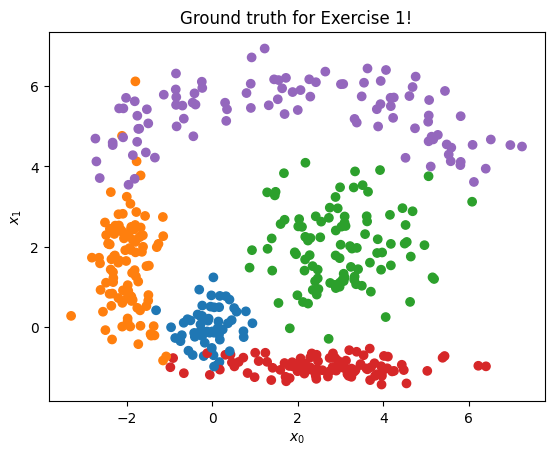

In [8]:
data_blobs, blob_labels = make_blobs(
    n_samples=[60, 100, 100, 100],
    random_state=42,
    centers=[[0, 0], [-2.0, 0.5], [3, 2.0], [0.4, -1]],
    cluster_std=[0.5, 0.4, 1, 0.2],
)
# Warp the blobs a bit
data_blobs[blob_labels == 1, 1] *= 3
data_blobs[blob_labels == 3, 0] *= 7

# Also add a moon
data_curve = make_moons(n_samples=200, shuffle=False, noise=0.2, random_state=42)[0][
    :100
]
data_curve = data_curve * np.asarray([[4, 2]]) + np.asarray([[2, 4]])
curve_labels = np.full(100, 4)

# Put it all together!
data = np.vstack(
    [
        data_blobs,
        data_curve,
    ]
)
true_labels = np.concatenate([blob_labels, curve_labels])
fig, ax = plot_clusters(data, true_labels)
ax.set(title="Ground truth for Exercise 1!")

This is already a pretty non-trivial dataset to cluster. Here's an example of trying it with KMeans:

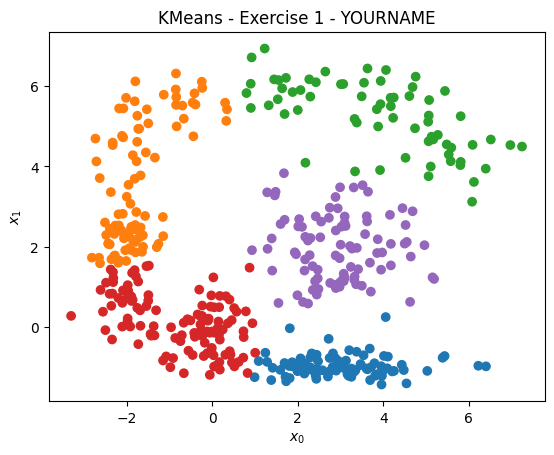

In [10]:
clusterer = KMeans(n_clusters=5)
labels = clusterer.fit_predict(data)
fig, ax = plot_clusters(
    data, labels, algorithm=clusterer, title="- Exercise 1 - YOURNAME"
)

Now it's your turn! Try different clustering algorithms from the list above and see what results you get. They are all already imported.

## EXERCISE 2: 

## Final thoughts

!Mention astrolink and extreme deconvolution